## Import Libraries

In [39]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Display properties
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML

# Date
import datetime
from datetime import date, timedelta


# Maps
from math import pi

# Storing and Reading data (pickle)
import pickle 


In [3]:
#Sklearn packages

# Import required packages for pre and post processing
from sklearn.preprocessing import normalize

# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram


## Call Pickle

In [74]:
with open('fifa_processed.pkl', 'rb') as f:
    fifa = pickle.load(f)

In [75]:
with open('predictors_processed.pkl', 'rb') as f:
    predictors_df = pickle.load(f)

Changing the categorical variables to dtype 'categorical'.

In [76]:
predictors_df[['Preferred Foot','International Reputation','Weak Foot','Skill Moves','Real Face']]=predictors_df[['Preferred Foot',
                                                                                                                  'International Reputation',
                                                                                                                  'Weak Foot','Skill Moves',
                                                                                                                  'Real Face']].astype('category')

In [77]:
predictors_df[list(predictors_df.loc[:,'Body Type':'Position_Group_Midfielder'])]=predictors_df[list(predictors_df.loc[:,'Body Type':'Position_Group_Midfielder'])].astype('category')

## 1.) Linear Regression

In [78]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

First, we are seperating value and wage of player out from the fifa data frame, as these are the values we would like to predict.

In [79]:
target_val = fifa.Value
target_wage = fifa.Wage

Next, we run a simple linear regression model to get a first impression of what is going on.

In [80]:
# with sklearn
lre = LinearRegression()
lre.fit(predictors_df, target_val)

print('Intercept: \n', lre.intercept_)
print('Coefficients: \n', lre.coef_)

model = sm.OLS(target_val, predictors_df).fit()
predictions = model.predict(predictors_df) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 -14799392093692.605
Coefficients: 
 [-3.48640994e+05 -3.79861117e+16  3.79861117e+16 -4.18271163e+04
 -3.34419519e+04  3.42066805e+06  7.79750731e+04  1.29307541e+05
  1.01594625e+06 -1.00820000e+04  1.72000000e+02  3.50699688e+04
  2.64960438e+05 -6.15350000e+03  1.44800000e+03  5.82435658e+14
 -2.08458554e+14 -3.73977104e+14  1.91772874e+14 -5.51351973e+13
  5.34971915e+13  1.63800592e+12 -1.91772874e+14  2.43524915e+15
 -1.15362983e+15 -1.28161931e+15 -2.10800106e+14 -1.05364314e+13
  6.48714259e+12  4.04928875e+12  2.10800106e+14  4.28481925e+14
 -1.78365680e+13 -2.76531297e+11  1.81130992e+13 -4.28481925e+14
  2.72935275e+12 -2.58876566e+14  1.39499087e+14  1.19377478e+14
 -2.72935278e+12  4.02817792e+13  4.02817792e+13  4.02817792e+13
  4.02817792e+13  4.02817792e+13 -1.12403274e+14 -1.12403274e+14
 -1.12403274e+14 -1.12403274e+14 -1.12403274e+14  1.40108006e+14
  1.40108006e+14  1.40108006e+14  1.40108006e+14  1.40108006e+14
  1.41050468e+14  1.41050468e+14  1.41050

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [81]:
pd.DataFrame(model.params, columns = ['Coefficients']).sort_values(by= 'Coefficients', ascending = False)

,Coefficients
Position_Potential,6.498542e+06
Club_Reputation,4.944524e+06
Position_LF,4.230000e+06
International Reputation,3.418787e+06
Position_RF,1.051158e+06
...,...
Continent_Africa,-1.024356e+07
Continent_North America,-1.036068e+07
Position_Group_Forward,-1.772547e+07
Position_Group_Defender,-1.862117e+07


## 2.) Baseline models and feature importance for Value prediction
### 2.1) Splitting data (stratified)

To make sure that our test set as well as all k-folds have a similar value and wage distribution, we stratify our data when splitting it into test and training set. To identify reasonable bins for stratifying, we first identify outliers and how big the portion of outliers is in the dataset. We, therefore, only consider exceptionally high values to be outliers, as the value distribution does not follow a normal distribution (rather a gamma distribution).

In [82]:
target_val_q25, target_val_q75 = np.percentile(target_val, 25), np.percentile(target_val, 75)
target_val_iqr = target_val_q75 - target_val_q25

cut_off = target_val_iqr * 1.5
target_val_upper = target_val_q75 + cut_off

target_val_outliers = [x for x in target_val if x > target_val_upper]

In [83]:
len(target_val_outliers)/len(target_val)

0.1369568808855113

Over 13% of the data are considered to have exceptionally high values. This group is big enough to build its own bin. We are going to split all the rest into four bins, each containing 25% of the left portion of the data. 

In [84]:
target_val_left=[x for x in target_val if x <= target_val_upper]
q25, q50, q75=np.percentile(target_val_left,25), np.percentile(target_val_left,50), np.percentile(target_val_left,75)

In [85]:
y_binned=[1 if x<=q25 else 2 if q25<x<=q50 else 3 if q50<x<=q75 else 4 if q75<x<=target_val_upper else 5 for x in target_val]

These bins can noew be used for stratifying our training and test set.

In [86]:
from sklearn.model_selection import train_test_split
train_predictors_val, test_predictors_val, train_target_val, test_target_val = train_test_split(predictors_df,
                                                                                                target_val,
                                                                                                test_size=0.2,
                                                                                                stratify=y_binned)

In [87]:
train_target_val.describe()

count    1.452700e+04
mean     2.416286e+06
std      5.578199e+06
min      0.000000e+00
25%      3.000000e+05
50%      6.750000e+05
75%      2.000000e+06
max      1.185000e+08
Name: Value, dtype: float64

In [88]:
test_target_val.describe()

count    3.632000e+03
mean     2.415513e+06
std      5.693633e+06
min      0.000000e+00
25%      3.000000e+05
50%      6.750000e+05
75%      1.925000e+06
max      1.020000e+08
Name: Value, dtype: float64

(array([3.464e+03, 1.020e+02, 3.900e+01, 1.500e+01, 3.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00e+00, 1.02e+07, 2.04e+07, 3.06e+07, 4.08e+07, 5.10e+07,
        6.12e+07, 7.14e+07, 8.16e+07, 9.18e+07, 1.02e+08]),
 <a list of 10 Patch objects>)

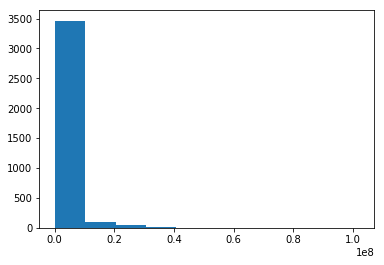

In [89]:
plt.hist(test_target_val)

(array([1.3955e+04, 3.9700e+02, 1.0000e+02, 3.6000e+01, 1.3000e+01,
        1.5000e+01, 6.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.0000e+00, 1.1850e+07, 2.3700e+07, 3.5550e+07, 4.7400e+07,
        5.9250e+07, 7.1100e+07, 8.2950e+07, 9.4800e+07, 1.0665e+08,
        1.1850e+08]),
 <a list of 10 Patch objects>)

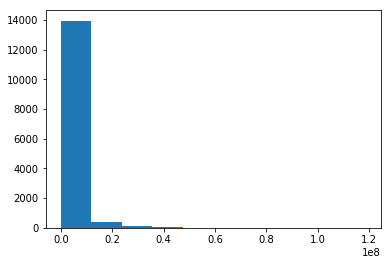

In [90]:
plt.hist(train_target_val)

The distribution of our test and training set look very similar. Just as we wanted them to be.

### 2.2) Baseline models
First, we are applying some models to our data without doing any parameter tuning or dropping any features. The obtained cross-validation, test and training errors can then be used as a baseline as we progress.

Before running fitting the models, we scale all numeric features. Since the dataframe only has data of type categorical, float and int, we select the latter for scaling.

In [96]:
train_predictors_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14527 entries, 2352 to 3088
Columns: 125 entries, Age to Position_Group_Midfielder
dtypes: category(45), float64(43), int64(37)
memory usage: 9.6 MB


In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_predictors_val[train_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']).columns] = scaler.fit_transform(train_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']))

test_predictors_val[test_predictors_val.select_dtypes(include=['float64','float32','int64','int32'], exclude=['category']).columns] = scaler.fit_transform(test_predictors_val.select_dtypes(include=['float64','float32','int64','int32'],exclude=['category']))


In [111]:
train_predictors_val[train_predictors_val.select_dtypes(include='category').columns]=train_predictors_val[train_predictors_val.select_dtypes(include='category').columns].astype('int')
test_predictors_val[test_predictors_val.select_dtypes(include='category').columns]=test_predictors_val[test_predictors_val.select_dtypes(include='category').columns].astype('int')

In [112]:
train_predictors_val.head()

,Age,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference,Body Type,Attack_WR,Defense_WR,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
2352,0.830678,1.119008,0.438663,0.933858,1,2,4,3,0,-0.660897,-0.185914,-0.27087,-0.093979,0.577058,-0.769086,1.072413,1.072413,1.072413,0.793856,0.956618,0.956618,0.956618,0.793856,0.895111,0.895111,0.895111,0.766306,0.758034,0.758034,0.758034,0.766306,0.195982,0.273175,0.273175,0.273175,0.195982,0.127732,0.127031,0.127031,0.127031,0.127732,0.227814,1.555018,1.250064,0.700955,1.807749,0.875600,1.398952,0.460327,0.604968,0.753665,0.021791,-0.258144,-0.103622,1.456576,0.495589,0.840450,0.663702,0.361225,0.850357,1.031372,-0.282925,-0.035024,1.690198,1.381849,1.808826,1.253339,-0.366513,-0.445397,-0.921909,-0.487448,-0.258910,-0.197647,-0.315237,-0.373192,0.487929,0.317731,1.326795,0.909212,0.270305,1.058027,1.220849,-0.596510,-0.333311,-0.933121,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
10398,-1.099877,-0.181516,0.601700,-0.144492,1,1,2,2,0,4.881154,-0.213024,-0.27087,0.667022,0.577058,0.641447,0.032576,0.032576,0.032576,-0.021222,0.040846,0.040846,0.040846,-0.021222,0.029422,0.029422,0.029422,-0.002962,0.212956,0.212956,0.212956,-0.002962,0.295782,0.519380,0.519380,0.519380,0.295782,0.376921,0.657341,0.657341,0.657341,0.376921,-0.098568,-0.386683,0.503145,0.156745,-0.278525,0.083478,-0.554364,-0.053891,0.278479,0.156906,-1.113294,-0.939070,-1.458548,0.128833,-1.491457,0.088369,-0.683690,-0.705828,1.009805,-0.058323,0.406536,0.593774,-0.356490,-0.172318,-0.036662,-0.932280,0.889772,0.800761,0.675376,-0.147919,-0.081409,-0.318895,-0.197628,-0.094611,-0.117974,0.317731,-0.043776,-0.033764,-1.281576,-0.113432,-0.017620,0.806363,-0.168474,0.913444,1,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3459,-0.456359,0.830002,0.927773,0.261260,0,1,2,2,0,-1.038764,-0.676474,-0.27087,1.428024,1.326389,1.090253,0.181124,0.181124,0.181124,0.266452,0.233640,0.233640,0.233640,0.266452,0.221797,0.221797,0.221797,0.381672,0.411166,0.411166,0.411166,0.381672,0.944479,0.864066,0.864066,0.864066,0.944479,0.974974,1.091232,1.091232,1.091232,0.974974,0.934975,-0.795462,1.192609,0.496876,-0.842383,0.558751,-0.608623,-1.025190,-0.374500,0.395610,0.088560,0.150411,-0.510100,0.903350,-1.136628,-0.374449,0.158430,0.926135,1.248976,-0.421555,1.095996,1.512786,-0.049487,-0.101674,-1.182137,0.204242,1.191280,1.216147,1.051207,-0.600624,-0.554745,-0.561392,-0.080020,-0.150327,-0.208859,0.317731,0.198090,-0.222359,-0.211313,0.319107,0.431495,1.181550,-0.392181,-0.009839,2,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
10383,0.401666,-0.181516,-1.028668,0.060211,1,1,3,3,0,-0.786852,-0.213024,-0.27087,-0.854981,-0.921605,-0.769086,0.379188,0.379188,0.379188,0.602073,0.474

Now that all numerical non-categorical data are scaled and categorical data are converted to integer (for the model) we proceed with fitting our baseline models.

In [113]:
import sklearn.model_selection as cv
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score, LeaveOneOut

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

dtr=DecisionTreeRegressor()
rfr=RandomForestRegressor()
xbr=xgb.XGBRegressor()
lre=LinearRegression()
svr=SVR()

models = [dtr,rfr,xbr,lre,svr]

for mod in models:
    mod.fit(train_predictors_val, train_target_val)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [114]:
test_error = []

# Sequentially fit all models and calculate test score
for mod in models:
    y_pred = mod.predict(test_predictors_val)
    mse_mod = MSE(test_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    test_error.append(rmse_mod)

In [115]:
cv_error=[]

for mod in models:
    MSE_cv_error = -cross_val_score(mod, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
    RMSE_cv = round((MSE_cv_error.mean())**(1/2))
    cv_error.append(RMSE_cv)

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [116]:
train_error=[]

# Sequentially fit all models and calculate train score
for mod in models:
    y_pred = mod.predict(train_predictors_val)
    mse_mod = MSE(train_target_val, y_pred)
    rmse_mod = round(mse_mod**(1/2))
    train_error.append(rmse_mod)

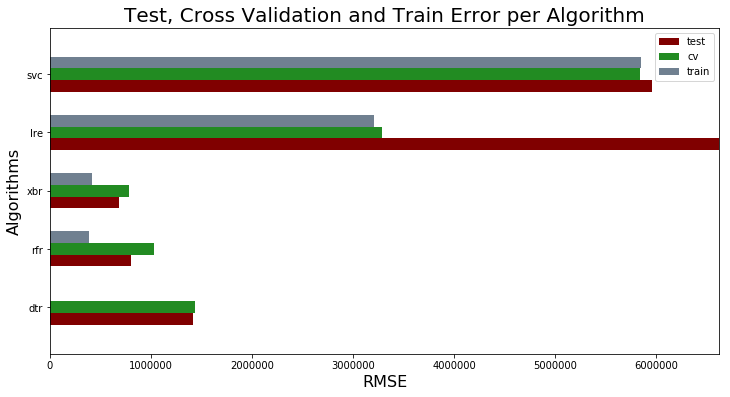

In [117]:
model_names = ['dtr','rfr','xbr','lre','svc']

error = pd.DataFrame(dict(graph=model_names,test_error=test_error, cv_error=cv_error, train_error=train_error)) 

ind = np.arange(len(error))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
ax.barh(ind, error.test_error, width, color='maroon', label='test')
ax.barh(ind + width, error.cv_error, width, color='forestgreen', label='cv')
ax.barh(ind + 2*width, error.train_error, width, color='slategrey', label='train')
ax.set_xlim(0, max(error.cv_error)+min(error.cv_error))
plt.xlabel('RMSE', fontsize=16)
plt.ylabel('Algorithms', fontsize=16)
plt.title('Test, Cross Validation and Train Error per Algorithm',fontsize=20)

ax.set(yticks=ind + width, yticklabels=error.graph, ylim=[2*width - 1, len(error)])
ax.legend()

plt.show()


In [118]:
error

,graph,test_error,cv_error,train_error
0,dtr,1.420859e+06,1436119.0,0.0
1,rfr,8.015190e+05,1029249.0,388090.0
2,xbr,6.832170e+05,782767.0,418658.0
3,lre,3.340413e+15,3284038.0,3207296.0
4,svc,5.952486e+06,5840854.0,5842973.0


While the Support Vector Regression is the most stable model, we can see that the Linear Regression has a very high test error (and, therefore, is overfit). The Decision Tree Regressor is also overfit, as its train error is zero. XGBoost and Random Forest also need some complexity reduction.<br>

In general, the errors are fluctuating between 500K and 6M, which serves as a good first impression.

### 2.3) Feature importance
Next, we are looking at the respective features to find out which ones have the most explanatory power and which ones should not be considered or could be transformed for further analysis. To do so, we are running each model using only the repsective feature. We then calculate the RMSE and compare the results. The features with a higher RMSE relative to the others are considered to have less explanatory power.

In [119]:
n_feats=predictors_df.shape[1]
col_names=pd.DataFrame(np.array(predictors_df.columns))

In [120]:
cv_score_features=pd.DataFrame()
best_models=[dtr,rfr,xbr,lre,svr]
index=0

for mod in best_models:
    score_list=[]
    index+=1
    for i in range(n_feats):
        X_feature = pd.DataFrame(np.array(predictors_df.iloc[:, i]).reshape(-1,1))
        scores = -cross_val_score(mod, X_feature, target_val, scoring='neg_mean_squared_error', n_jobs=-1)
        score_list.append(scores.mean())
    cv_score_features[str(index)]=score_list

C:\Users\wehrm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [121]:
s = {'Feature': col_names[0],
     'DTR': cv_score_features['1'],
     'RFR': cv_score_features['2'],
     'XBR': cv_score_features['3'],
     'LRE': cv_score_features['4'],
     'SVC': cv_score_features['5']}
feature_scores=pd.DataFrame(data=s)
feature_scores=feature_scores.sort_values(by=['XBR'])
feature_scores

,Feature,DTR,RFR,XBR,LRE,SVC
1,Overall,3.291131e+13,3.291065e+13,3.291657e+13,6.343037e+13,3.559205e+13
50,BallControl,3.363363e+13,3.409084e+13,3.359435e+13,3.976522e+13,3.559360e+13
22,RW,3.404289e+13,3.427806e+13,3.403353e+13,4.016000e+13,3.559329e+13
18,LW,3.404289e+13,3.423585e+13,3.403353e+13,4.016000e+13,3.559329e+13
23,LAM,3.503860e+13,3.493203e+13,3.501742e+13,4.009771e+13,3.559356e+13
...,...,...,...,...,...,...
84,Potential_Difference,4.134340e+13,4.136406e+13,4.134291e+13,4.143626e+13,3.559468e+13
0,Age,4.170572e+13,4.192899e+13,4.170205e+13,4.218390e+13,3.559363e+13
74,GKReflexes,4.405168e+13,4.180389e+13,4.172554e+13,4.058282e+13,3.559485e+13
10,Joined,4.730089e+13,4.477203e+13,4.236384e+13,4.082795e+13,3.559494e+13


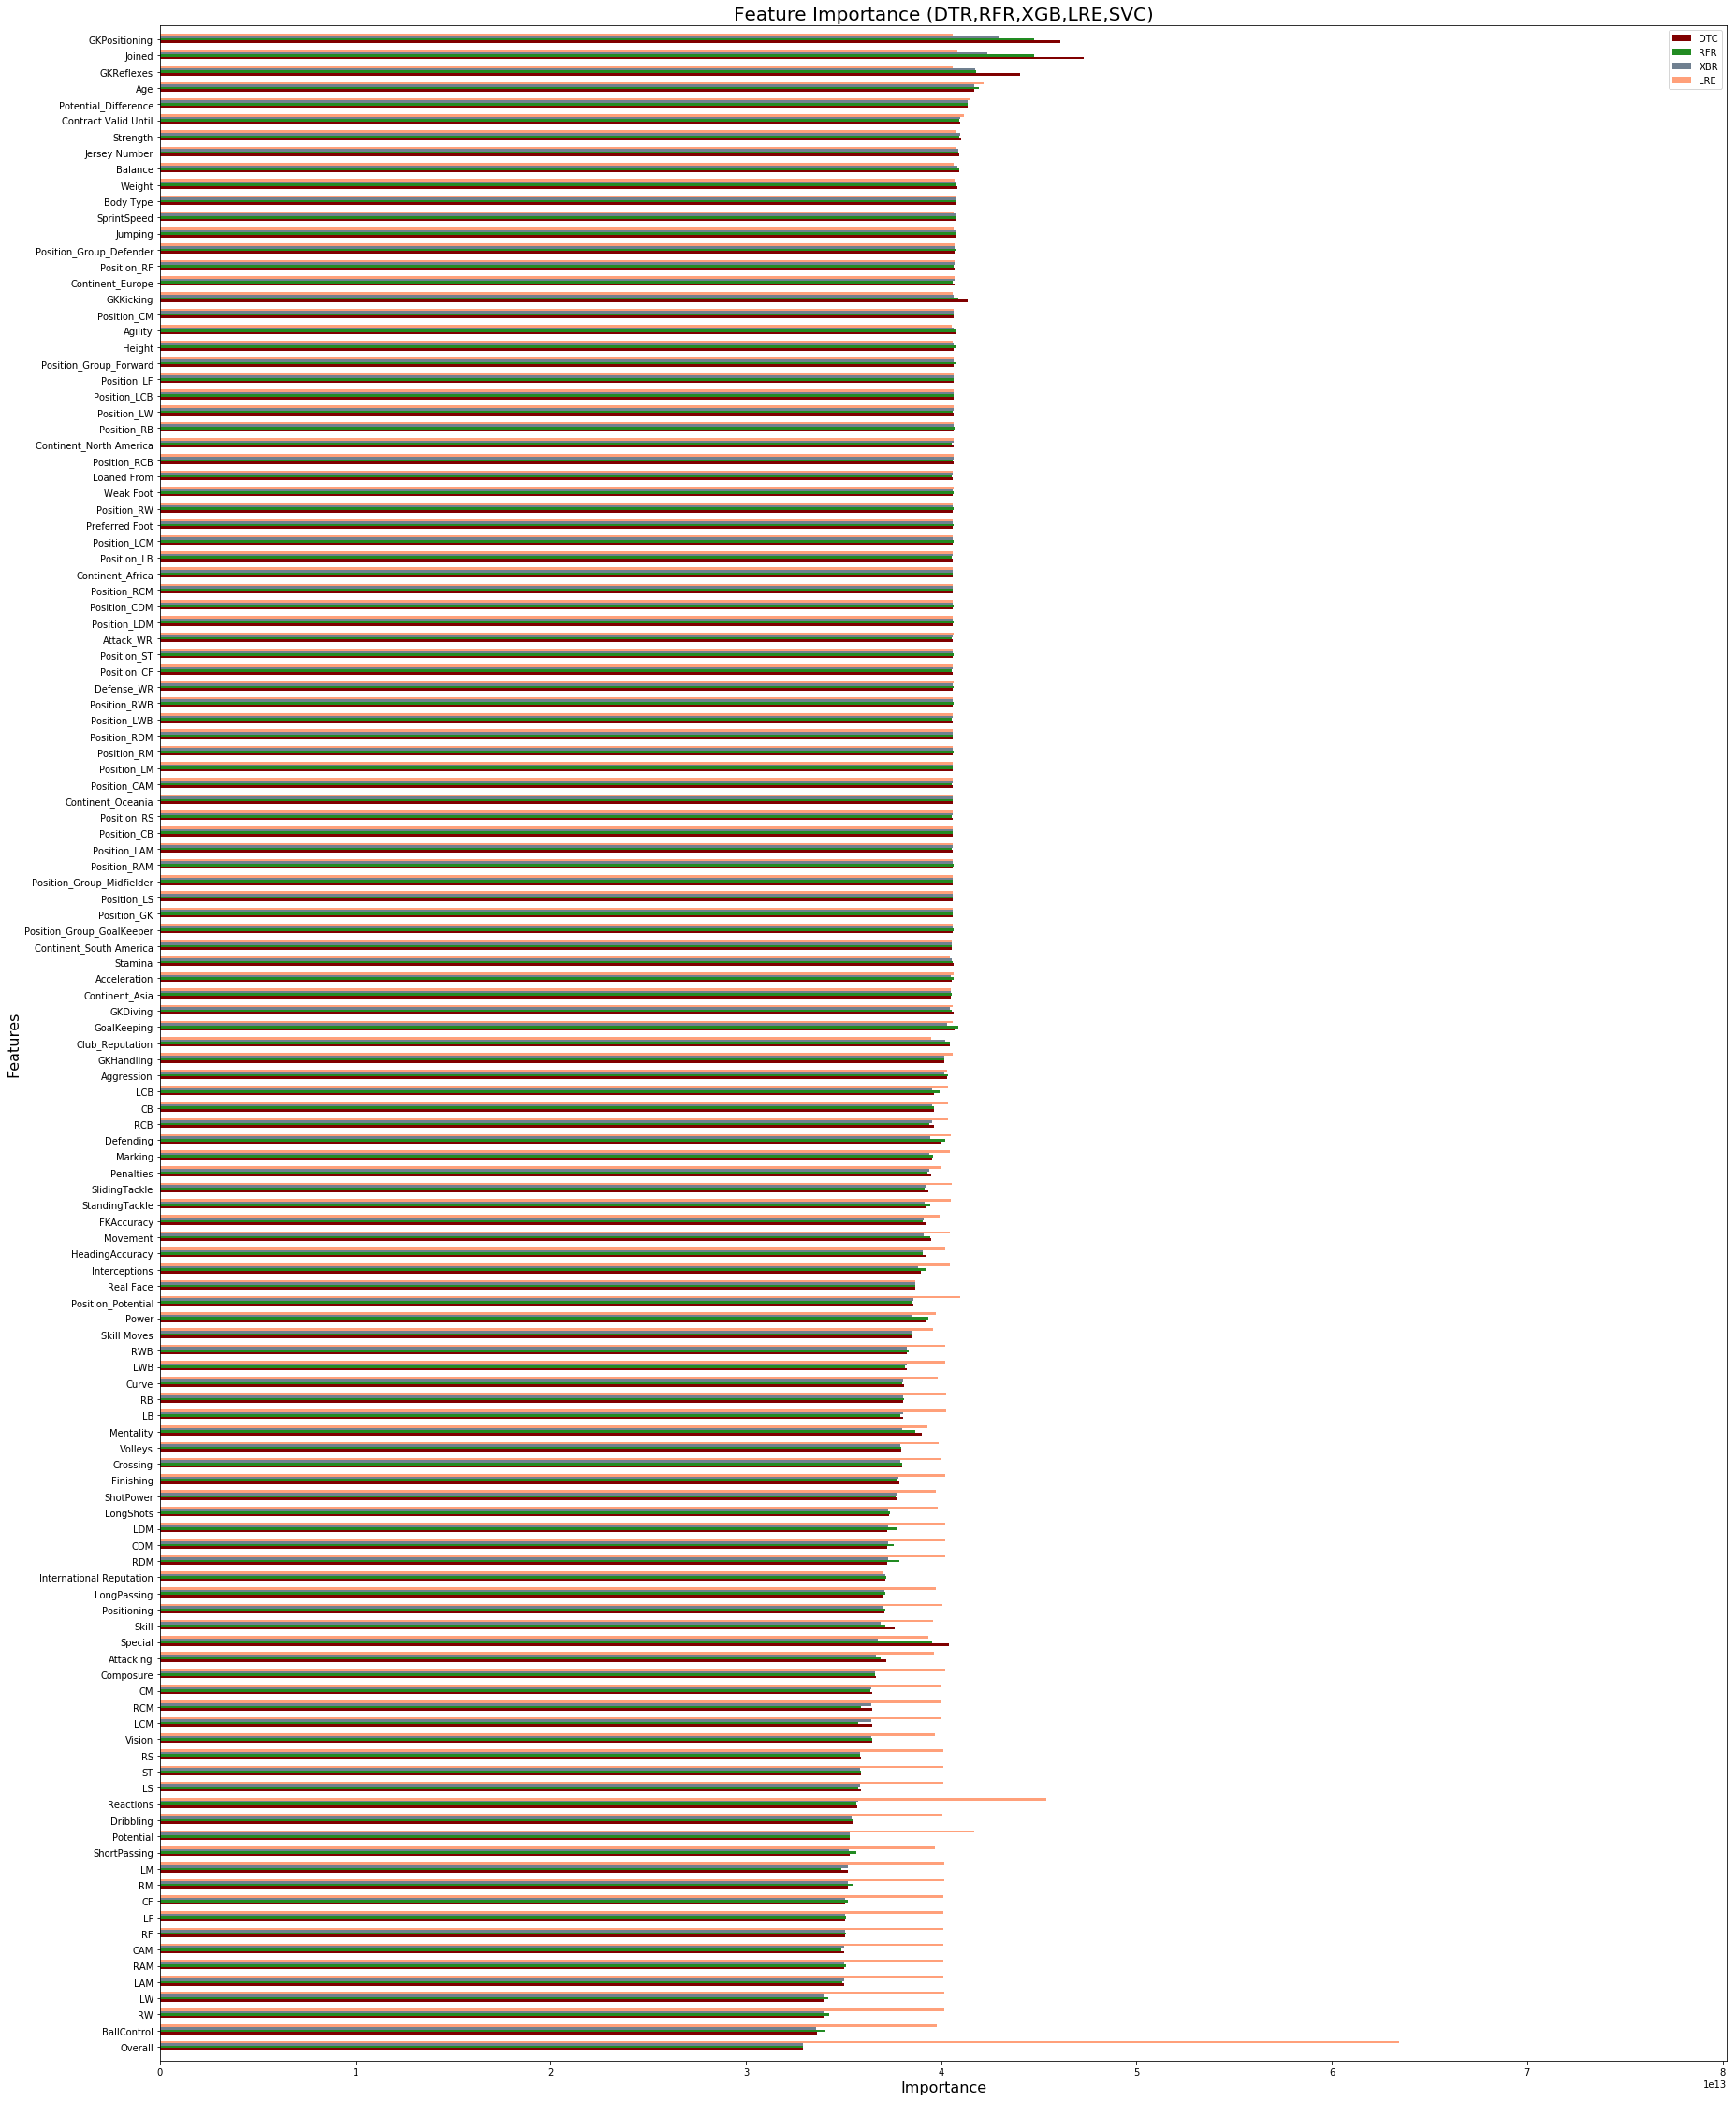

In [122]:
importance = pd.DataFrame(dict(graph=feature_scores['Feature'],
                               DTR=feature_scores['DTR'],
                               RFR=feature_scores['RFR'],
                               XBR=feature_scores['XBR'],
                               LRE=feature_scores['LRE'],
                               SVC=feature_scores['SVC'])) 

ind = np.arange(len(importance))
width = 0.15

fig, ax = plt.subplots(figsize=(30,40))
ax.barh(ind, importance.DTR, width, color='maroon', label='DTC')
ax.barh(ind + width, importance.RFR, width, color='forestgreen', label='RFR')
ax.barh(ind + 2*width, importance.XBR, width, color='slategrey', label='XBR')
ax.barh(ind + 3*width, importance.LRE, width, color='lightsalmon', label='LRE')
ax.set_xlim(0, max(importance.DTR)+min(importance.DTR))
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.title('Feature Importance (DTR,RFR,XGB,LRE,SVC)',fontsize=20)

ax.set(yticks=ind + width, yticklabels=importance.graph, ylim=[2*width - 1, len(importance)])
ax.legend()

plt.show()

The overall score of a player and his ball control turn out to be the most important features for predicting the value. This is followed by positions attributes (how high a player's score is at a certain position), most of which are attacking or midfield positions. To reduce the features in our model, we are grouping these positions skills into three groups 'Forward Skills', 'Midfield Skills' and 'Defence Skills'.

Grouping position skills and drop:

In [123]:
predictors_df['Forward_Skill'] = predictors_df.loc[:,['LS',  'ST', 'RS',  'LW', 'LF', 'CF', 'RF', 'RW']].mean(axis=1)

predictors_df['Midfield_Skill'] = predictors_df.loc[:,['LAM','CAM','RAM', 'LM', 'LCM', 'CM' ,'RCM', 'RM','LDM', 'CDM', 'RDM']].mean(axis=1)

predictors_df['Defence_Skill'] = predictors_df.loc[:,['LWB','RWB', 'LB','LCB','CB','RCB','RB']].mean(axis=1)

predictors_df = predictors_df.drop(['LS',  'ST', 'RS',  'LW', 'LF', 'CF', 'RF', 'RW',
          'LAM','CAM','RAM', 'LM', 'LCM', 'CM' ,'RCM', 'RM','LDM', 'CDM', 'RDM',
          'LWB','RWB', 'LB','LCB','CB','RCB','RB'], axis = 1)

Furthermore, we are removing single attributes like Finishing, HeadingAccuracy etc., as we have already combined them into skill groups (e.g., 'Attacking') in the EDA and Cleaning part. Keeping them would mean to overweigh these features.

In [124]:
predictors_df=predictors_df.drop(['Crossing',
 'Finishing',
 'HeadingAccuracy',
 'ShortPassing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FKAccuracy',
 'LongPassing',
 'BallControl',
 'Acceleration',
 'SprintSpeed',
 'Agility',
 'Reactions',
 'Balance',
 'ShotPower',
 'Jumping',
 'Stamina',
 'Strength',
 'LongShots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'StandingTackle',
 'SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes'], axis = 1)

In [125]:
predictors_df.shape

(18159, 68)

After doing so, we are left with 68 columns.<br>

Once again, we run our code for feature importance to see how well the newly created groups perform.

In [126]:
n_feats=predictors_df.shape[1]
col_names=pd.DataFrame(np.array(predictors_df.columns))

In [128]:
cv_score_features=pd.DataFrame()
best_models=[dtr,rfr,xbr,lre,svr]
index=0

for mod in best_models:
    score_list=[]
    index+=1
    for i in range(n_feats):
        X_feature = pd.DataFrame(np.array(predictors_df.iloc[:, i]).reshape(-1,1))
        scores = -cross_val_score(mod, X_feature, target_val, scoring='neg_mean_squared_error', n_jobs=-1)
        score_list.append(scores.mean())
    cv_score_features[str(index)]=score_list

In [129]:
s = {'Feature': col_names[0],
     'DTR': cv_score_features['1'],
     'RFR': cv_score_features['2'],
     'XBR': cv_score_features['3'],
     'LRE': cv_score_features['4'],
     'SVR': cv_score_features['5']}

feature_scores=pd.DataFrame(data=s)
feature_scores=feature_scores.sort_values(by=['RFR'])
feature_scores

,Feature,DTR,RFR,XBR,LRE,SVR
1,Overall,3.291131e+13,3.292570e+13,3.291657e+13,6.343037e+13,3.559205e+13
66,Midfield_Skill,3.483528e+13,3.536940e+13,3.495862e+13,4.006929e+13,3.559356e+13
2,Potential,3.532868e+13,3.541960e+13,3.533525e+13,4.168772e+13,3.559093e+13
65,Forward_Skill,3.587262e+13,3.595072e+13,3.550093e+13,4.012378e+13,3.559361e+13
17,Attacking,3.718240e+13,3.697770e+13,3.665597e+13,3.964200e+13,3.559391e+13
5,International Reputation,3.712385e+13,3.711110e+13,3.712412e+13,3.702092e+13,3.559517e+13
18,Skill,3.761462e+13,3.733318e+13,3.691074e+13,3.960158e+13,3.559421e+13
7,Skill Moves,3.846869e+13,3.840074e+13,3.846849e+13,3.957370e+13,3.558797e+13
16,Position_Potential,3.859366e+13,3.858648e+13,3.859348e+13,4.097735e+13,3.559578e+13
8,Real Face,3.868142e+13,3.869777e+13,3.868123e+13,3.868142e+13,3.559496e+13


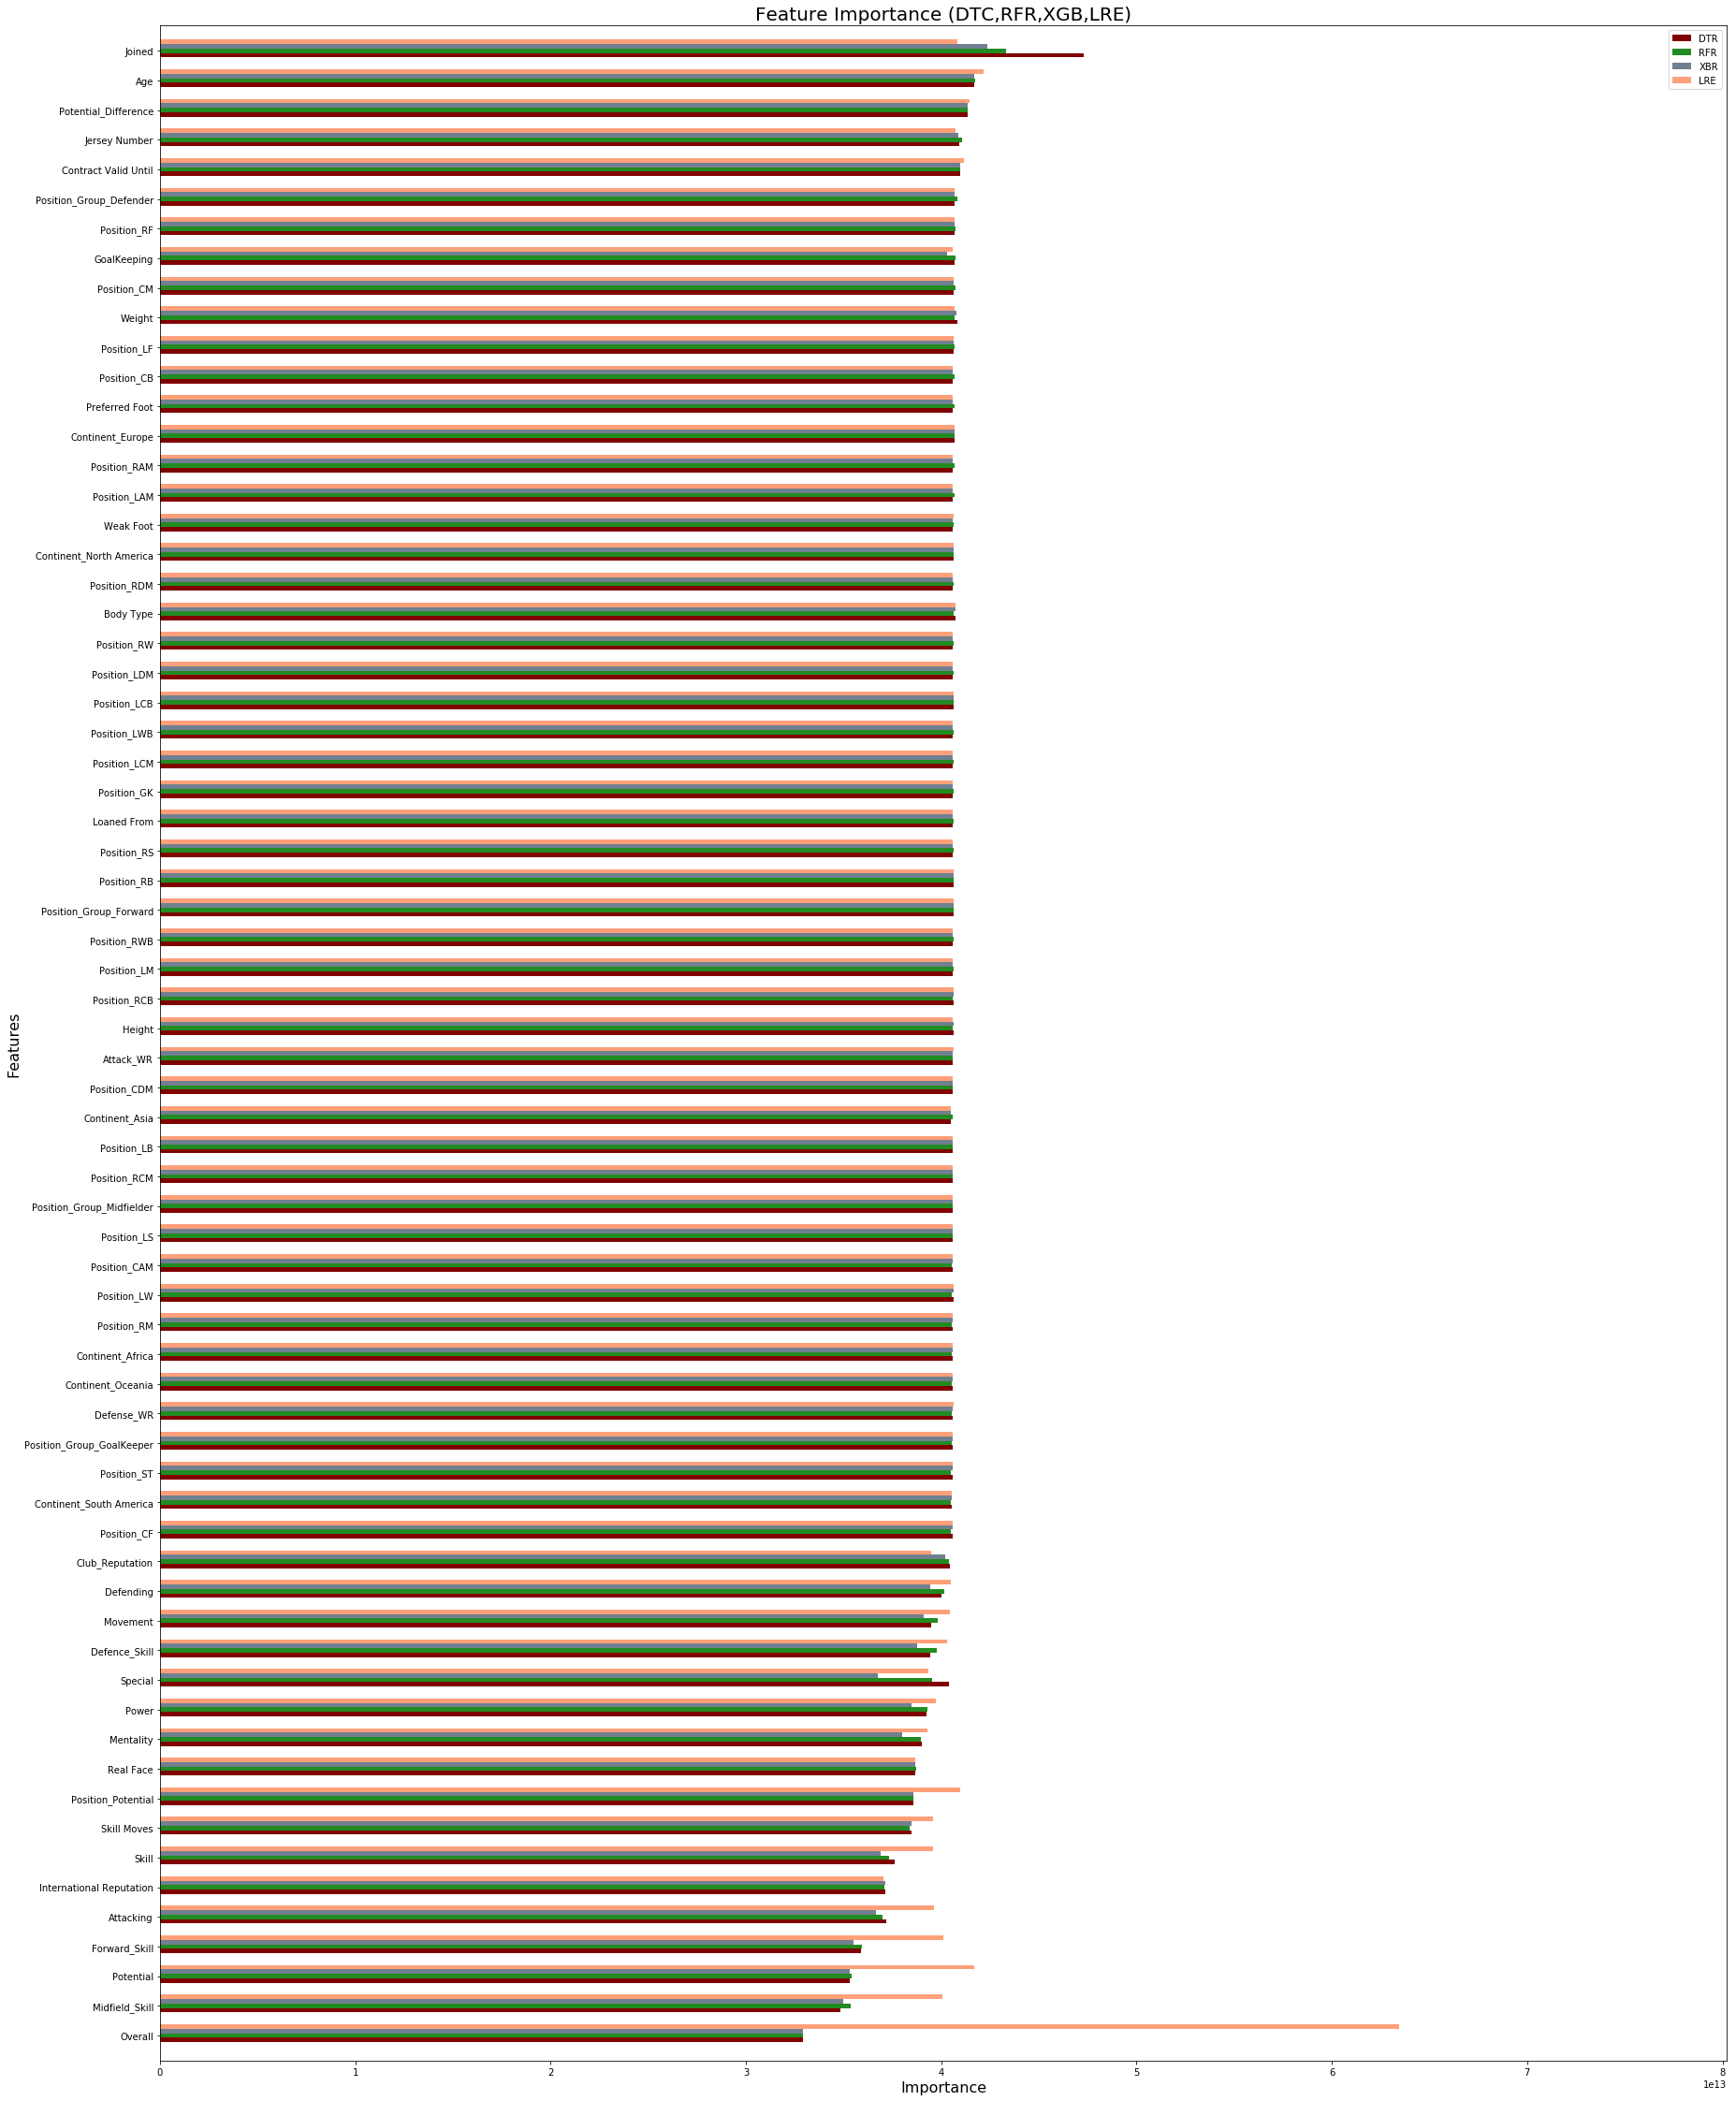

In [130]:
importance = pd.DataFrame(dict(graph=feature_scores['Feature'], DTR=feature_scores['DTR'], RFR=feature_scores['RFR'], XBR=feature_scores['XBR'],LRE=feature_scores['LRE'])) 

ind = np.arange(len(importance))
width = 0.15

fig, ax = plt.subplots(figsize=(30,40))
ax.barh(ind, importance.DTR, width, color='maroon', label='DTR')
ax.barh(ind + width, importance.RFR, width, color='forestgreen', label='RFR')
ax.barh(ind + 2*width, importance.XBR, width, color='slategrey', label='XBR')
ax.barh(ind + 3*width, importance.LRE, width, color='lightsalmon', label='LRE')
ax.set_xlim(0, max(importance.DTR)+min(importance.DTR))
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.title('Feature Importance (DTC,RFR,XGB,LRE)',fontsize=20)

ax.set(yticks=ind + width, yticklabels=importance.graph, ylim=[2*width - 1, len(importance)])
ax.legend()

plt.show()

We see that the position dummies are all on the higher end of the graph, meaning they have less explanatory power. Also, from a logical perspective, a player should have the highest skills for his position. Therefore, the position dummies are somewhat covered already by the Forward, Midfield and Defender Skill columns. Dropping position dummies:

In [131]:
predictors_df=predictors_df.drop(['Position_CAM', 'Position_CB', 'Position_CDM',
       'Position_CF', 'Position_CM', 'Position_GK', 'Position_LAM',
       'Position_LB', 'Position_LCB', 'Position_LCM', 'Position_LDM',
        'Position_LF', 'Position_LM', 'Position_LS', 'Position_LW',
        'Position_LWB', 'Position_RAM', 'Position_RB', 'Position_RCB',
        'Position_RCM', 'Position_RDM', 'Position_RF', 'Position_RM',
       'Position_RS', 'Position_RW', 'Position_RWB', 'Position_ST'], axis=1)

In [132]:
predictors_df.shape

(18159, 41)

# EVERYTHING BELOW THIS IS WIP

Re-running feature importance:

In [101]:
n_feats=predictors_df.shape[1]
col_names=pd.DataFrame(np.array(predictors_df.columns))

In [102]:
cv_score_features=pd.DataFrame()
best_models=[dtc,rfr,xbr,lre]
index=0

for mod in best_models:
    score_list=[]
    index+=1
    for i in range(n_feats):
        X_feature = pd.DataFrame(np.array(predictors_df.iloc[:, i]).reshape(-1,1))
        scores = -cross_val_score(mod, X_feature, target_val, scoring='neg_mean_squared_error', n_jobs=-1)
        score_list.append(scores.mean())
    cv_score_features[str(index)]=score_list

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [103]:
s = {'Feature': col_names[0], 'DTC': cv_score_features['1'], 'RFR': cv_score_features['2'], 'XBR': cv_score_features['3'], 'LRE': cv_score_features['4']}
feature_scores=pd.DataFrame(data=s)
feature_scores=feature_scores.sort_values(by=['RFR'])
feature_scores

,Feature,DTC,RFR,XBR,LRE
1,Overall,3.291131e+13,3.288202e+13,3.291657e+13,6.343037e+13
39,Midfield_Skill,3.483528e+13,3.537484e+13,3.495862e+13,4.006929e+13
2,Potential,3.532868e+13,3.537913e+13,3.533525e+13,4.168772e+13
38,Forward_Skill,3.587262e+13,3.572715e+13,3.550093e+13,4.012378e+13
18,Skill,3.761462e+13,3.688433e+13,3.691074e+13,3.960158e+13
17,Attacking,3.718240e+13,3.698214e+13,3.665597e+13,3.964200e+13
5,International Reputation,3.712385e+13,3.712645e+13,3.712412e+13,3.702092e+13
7,Skill Moves,3.846869e+13,3.845236e+13,3.846849e+13,3.957370e+13
16,Position_Potential,3.859366e+13,3.864125e+13,3.859348e+13,4.097735e+13
8,Real Face,3.868142e+13,3.868709e+13,3.868123e+13,3.868142e+13


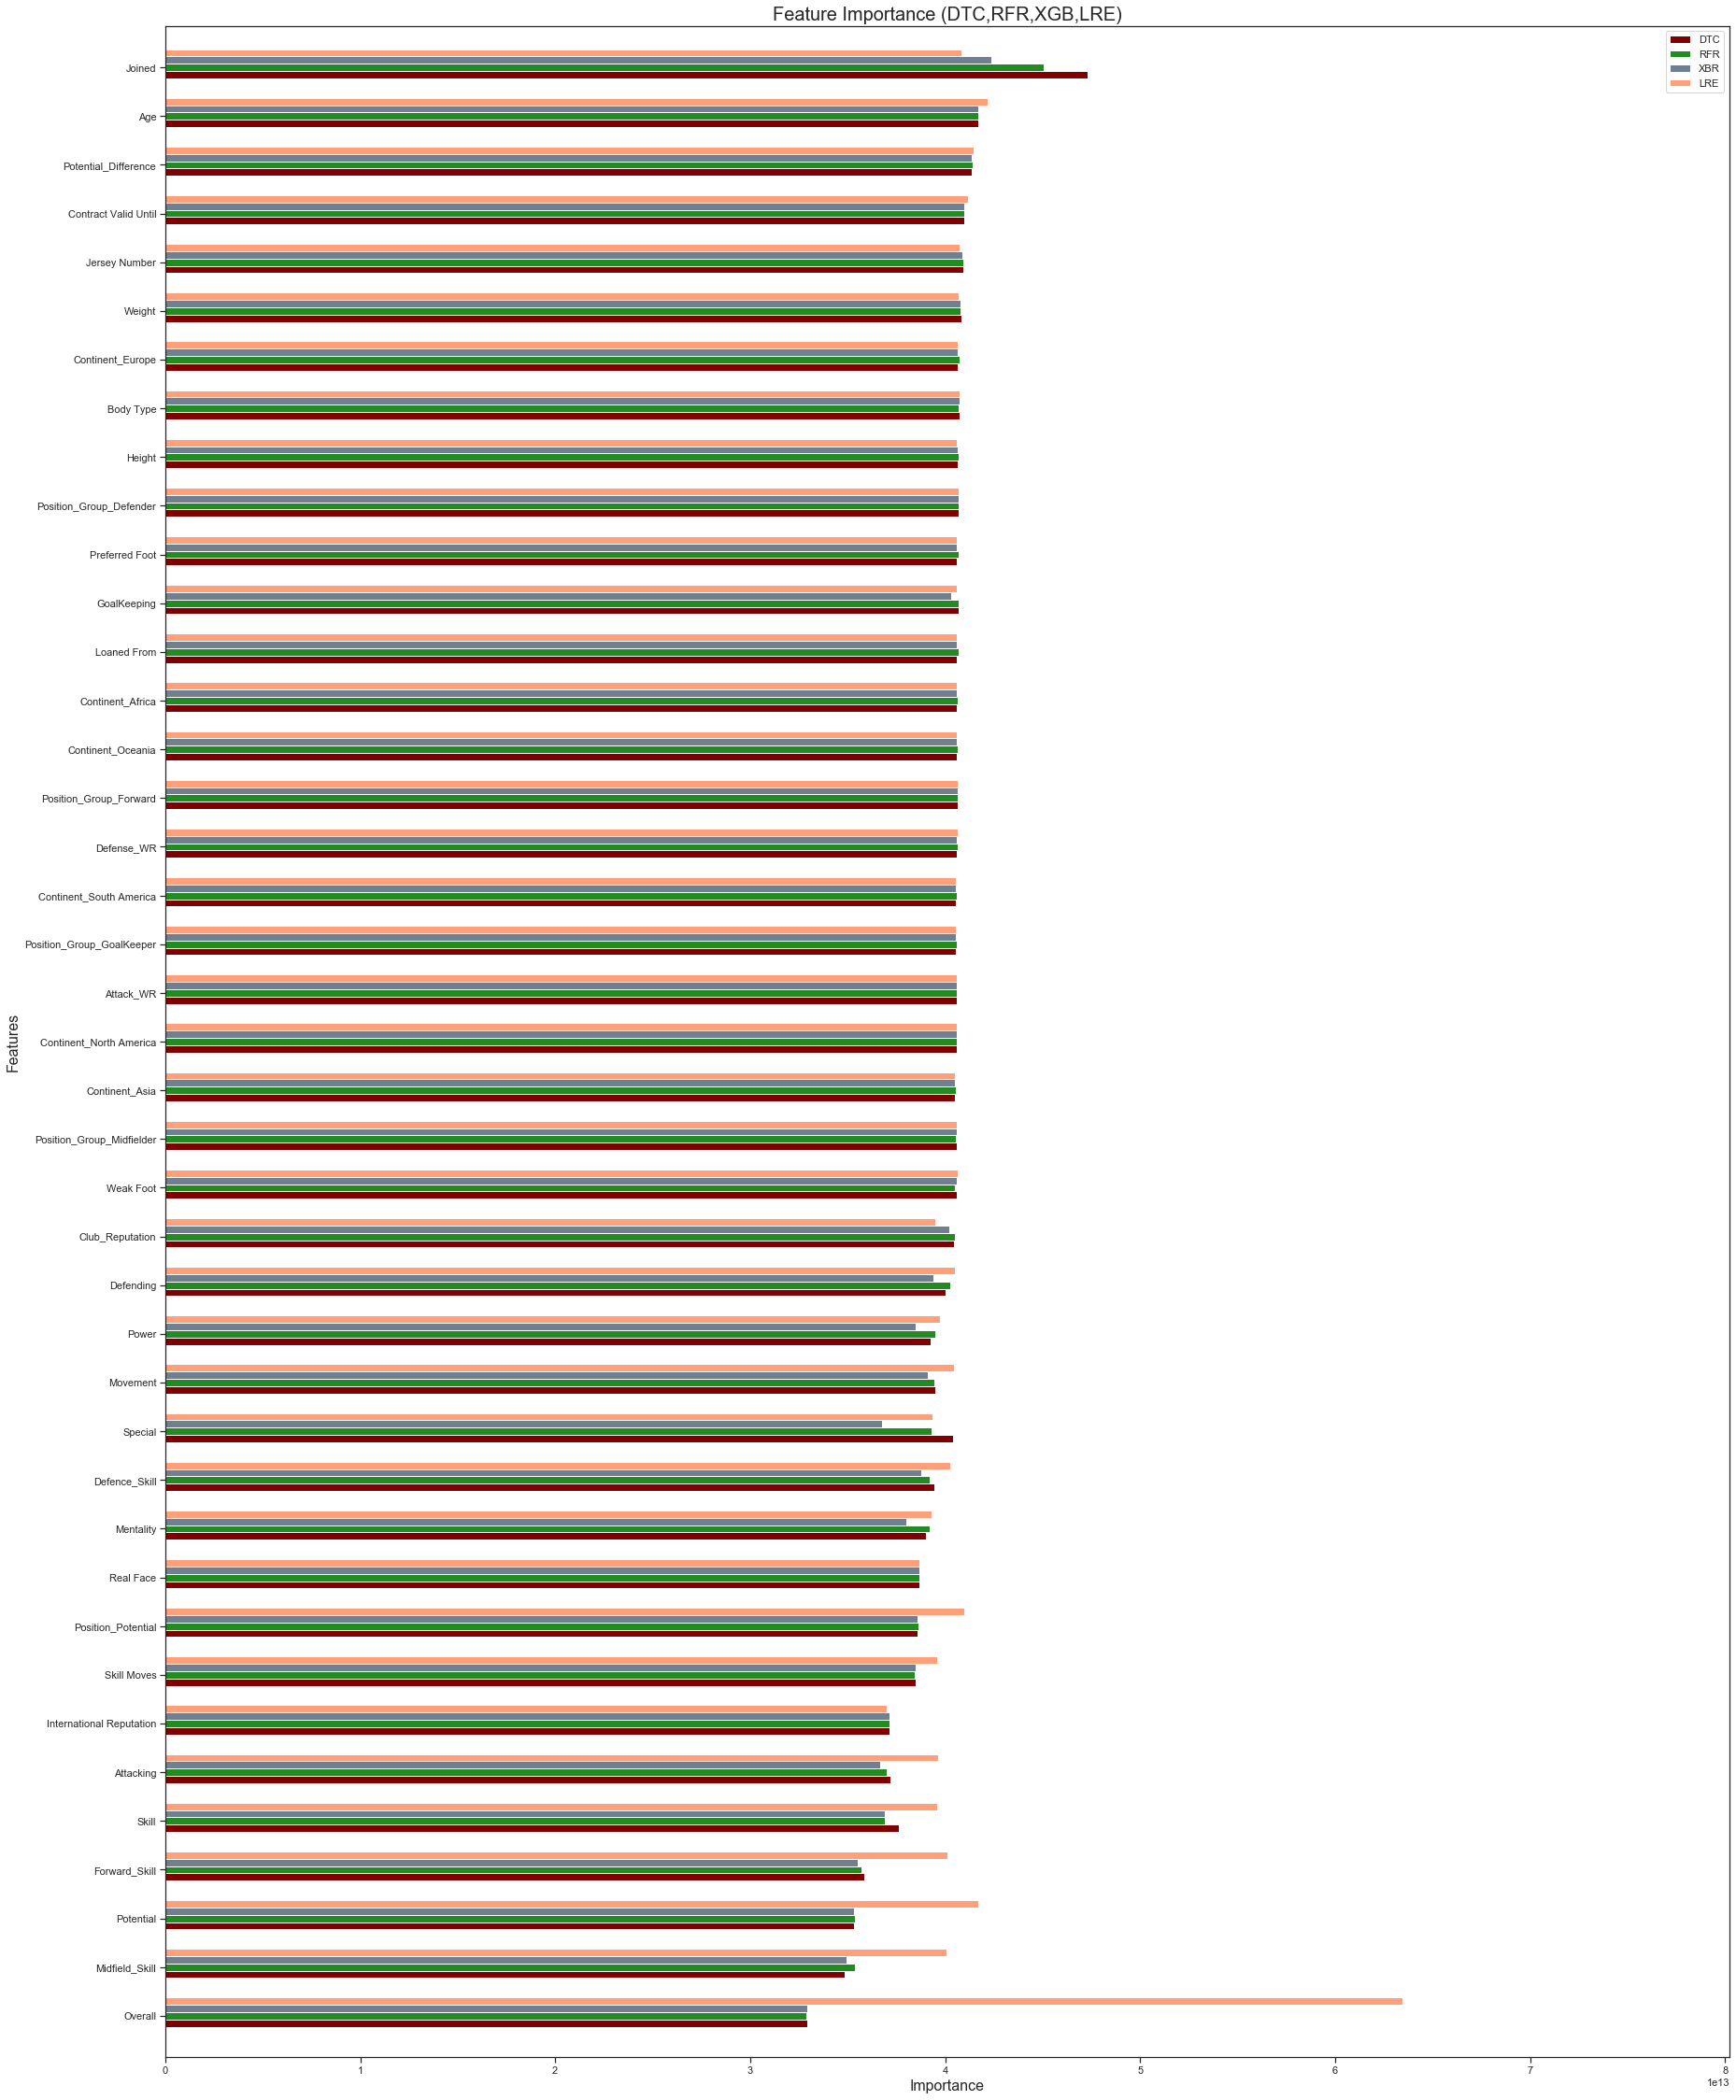

In [104]:
importance = pd.DataFrame(dict(graph=feature_scores['Feature'], DTC=feature_scores['DTC'], RFR=feature_scores['RFR'], XBR=feature_scores['XBR'],LRE=feature_scores['LRE'])) 

ind = np.arange(len(importance))
width = 0.15

fig, ax = plt.subplots(figsize=(30,40))
ax.barh(ind, importance.DTC, width, color='maroon', label='DTC')
ax.barh(ind + width, importance.RFR, width, color='forestgreen', label='RFR')
ax.barh(ind + 2*width, importance.XBR, width, color='slategrey', label='XBR')
ax.barh(ind + 3*width, importance.LRE, width, color='lightsalmon', label='LRE')
ax.set_xlim(0, max(importance.DTC)+min(importance.DTC))
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.title('Feature Importance (DTC,RFR,XGB,LRE)',fontsize=20)

ax.set(yticks=ind + width, yticklabels=importance.graph, ylim=[2*width - 1, len(importance)])
ax.legend()

plt.show()

Dropping Jersey Number and Potential Difference to avoid overfitting:

In [94]:
predictors_df=predictors_df.drop(['Potential_Difference','Jersey Number'],axis=1)

Re-running baseline model:

In [106]:
train_predictors_val, test_predictors_val, train_target_val, test_target_val = train_test_split(predictors_df,
                                                                                                target_val,
                                                                                                test_size=0.2,
                                                                                                stratify=y_binned)

In [107]:
train_predictors_val.shape

(14527, 39)

In [108]:
numeric_cols=['Age', 'Overall', 'Potential', 'Value', 'Wage',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Real Face',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Club_Reputation',
       'Position_Potential', 'Attacking', 'Skill', 'Movement', 'Power',
       'Mentality', 'Defending', 'GoalKeeping', 'Potential_Difference']

from sklearn.preprocessing import StandardScaler

scl = StandardScaler()

fifa_num_df = pd.DataFrame(scl.fit_transform(fifa_numeric_cols), columns=numeric_cols)

fifa_num_df.head()

,Age,Overall,Potential,Value,Wage,International Reputation,Weak Foot,Skill Moves,Real Face,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Club_Reputation,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Potential_Difference
0,1.258441,4.013364,3.697415,2.213984,-1.819966,9.864420,1.593944,2.167171,3.15893,-0.598105,5.920259,-0.273523,0.673625,-1.670713,-0.447583,1.818665,1.818665,1.818665,1.901392,1.973099,1.973099,1.973099,1.901392,1.957564,1.957564,1.957564,1.828702,1.603458,1.603458,1.603458,1.828702,0.646400,0.519988,0.519988,0.519988,0.646400,0.427328,-0.114632,-0.114632,-0.114632,0.427328,1.865922,2.532567,1.018552,2.130287,2.435355,2.201445,2.491426,2.925736,2.237037,2.255198,1.767621,1.452129,1.862187,3.680643,2.195382,1.713704,0.246247,0.552403,-0.502679,2.434582,-0.453087,-1.193365,2.255244,2.869906,1.684414,3.266205,-0.717531,-0.909268,-0.923569,-0.599961,-0.318908,-0.074659,-0.140241,-0.485161,5.045701,0.316222,2.367037,2.652691,2.491225,1.477531,1.581089,-0.874941,-0.333393,-0.935691
1,1.686666,4.013364,3.697415,2.309273,0.549461,9.864420,1.593944,3.489672,3.15893,-0.786241,-0.693701,-0.273523,1.437527,1.019186,1.091577,1.967451,1.967451,1.967451,1.757292,1.828258,1.828258,1.828258,1.757292,1.716682,1.716682,1.716682,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.519988,0.519988,0.519988,0.696360,0.527106,0.174842,0.174842,0.174842,0.527106,1.865922,2.481351,2.111799,1.518005,2.491871,1.725503,1.839066,1.895887,1.584613,2.135338,1.633639,1.793436,1.591288,3.791628,0.426820,2.293836,2.530565,1.559053,1.090102,2.382660,0.410595,-0.855140,2.306451,2.021639,2.321210,3.178760,-0.968738,-0.770785,-1.064489,-0.543447,-0.318908,-0.074659,-0.140241,-0.318073,6.286015,1.850361,2.501665,2.010038,2.044295,2.777910,1.853981,-0.956497,-0.286336,-0.935691
2,0.187878,3.724114,3.534396,1.997752,0.549461,9.864420,3.108090,3.489672,3.15893,-0.598105,-0.253373,-0.273523,1.437527,-0.923519,-1.024769,1.620283,1.620283,1.620283,1.757292,1.779978,1.779978,1.779978,1.757292,1.764859,1.764859,1.764859,1.684202,1.454577,1.454577,1.454577,1.684202,0.696360,0.470696,0.470696,0.470696,0.696360,0.477217,-0.114632,-0.114632,-0.114632,0.477217,1.593650,2.122842,0.558238,1.722099,2.322322,2.148563,2.219609,2.525239,1.649855,2.195268,1.968594,1.725175,2.200811,3.569658,1.417214,1.423639,-0.345984,1.118643,-1.299069,1.811528,0.007543,-0.516916,1.999208,2.375083,2.066492,3.091316,-1.018980,-1.093911,-0.594753,-0.430420,-0.437206,-0.074659,-0.081536,-0.318073,5.005080,1.850361,1.976617,2.362867,2.491225,1.026010,1.772114,-0.923875,-0.274572,-0.751109
3,0.401990,3.579489,3.534396,-0.465097,0.549461,7.326477,0.079797,-1.800331,3.15893,-1.162514,2.619735,-0.273523,-0.090277,1.766380,0.129602,-2.545731,-2.545731,-2.545731,-2.517663,-2.516977,-2.516977,-2.516977,-2.517663,-2.522831,-2.522831,-2.522831,-2.554472,-2.565223,-2.565223,-2.565223,-2.554472,-2.551047,-2.486788,-2.486788,-2.486788,-2.551047,-2.516127,-2.382176,-2.382176,-2.382176,-2.516127,-1.782517,-1.667116,-1.800873,-0.590969,-1.690356,-1.976272,-1.422733,-1.365303,-0.111691,-0.981022,-0.510075,-0.459193,-0.237281,3.125717,-1.483228,-1.419003,0.161642,-1.272151,-0.104484,-1.822948,-1.028876,-0.806823,-1.943748,1.031994,-0.544371,0.817758,-1.621878,-1.232393,-1.534226,4.147180,4.058124,4.288340,4.203960,4.304691,4.368675,-2.752054,-1.819883,-1.329238,-0.190353,-1.430261,-0.779428,-1.494763,4.254638,-0.566526
4,0.401990,3.579489,3.371377,2.503515,0.549461,7.326477,3.108090,2.167171,3.15893,-0.7

In [109]:
scaler = StandardScaler()
train_predictors_val = scaler.fit_transform(train_predictors_val)
test_predictors_val = scaler.fit_transform(test_predictors_val)

In [110]:
dtc=DecisionTreeRegressor()
rfr=RandomForestRegressor()
xbr=xgb.XGBRegressor()
lre=LinearRegression()

models = [dtc,rfr,xbr,lre]

for mod in models:
    mod.fit(train_predictors_val, train_target_val)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[21:18:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [111]:
test_error = []

# Sequentially fit all models and calculate test score
for mod in models:
    y_pred = mod.predict(test_predictors_val)
    mse_mod = MSE(test_target_val, y_pred)
    rmse_mod = mse_mod**(1/2)
    test_error.append(rmse_mod)

In [112]:
cv_error=[]

for mod in models:
    MSE_cv_error = -cross_val_score(mod, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
    RMSE_cv = (MSE_cv_error.mean())**(1/2)
    cv_error.append(RMSE_cv)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [113]:
train_error=[]

# Sequentially fit all models and calculate train score
for mod in models:
    y_pred = mod.predict(train_predictors_val)
    mse_mod = MSE(train_target_val, y_pred)
    rmse_mod = mse_mod**(1/2)
    train_error.append(rmse_mod)

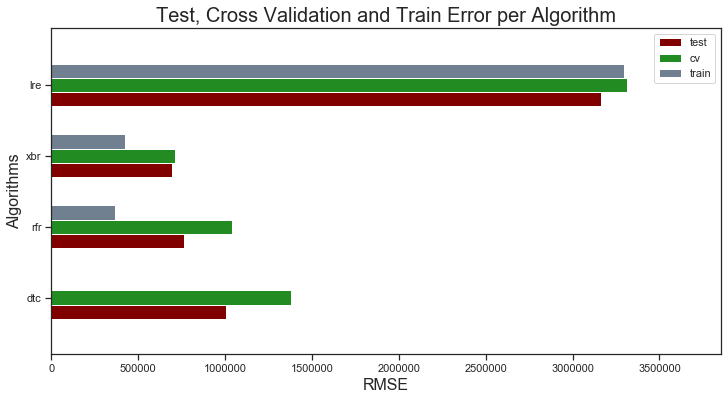

In [114]:
model_names = ['dtc','rfr','xbr','lre']

error = pd.DataFrame(dict(graph=model_names,test_error=test_error, cv_error=cv_error, train_error=train_error)) 
#error = pd.DataFrame(dict(graph=model_names,test_error=test_error, train_error=train_error)) 

ind = np.arange(len(error))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
ax.barh(ind, error.test_error, width, color='maroon', label='test')
ax.barh(ind + width, error.cv_error, width, color='forestgreen', label='cv')
ax.barh(ind + 2*width, error.train_error, width, color='slategrey', label='train')
ax.set_xlim(0, max(error.test_error)+min(error.test_error))
plt.xlabel('RMSE', fontsize=16)
plt.ylabel('Algorithms', fontsize=16)
plt.title('Test, Cross Validation and Train Error per Algorithm',fontsize=20)

ax.set(yticks=ind + width, yticklabels=error.graph, ylim=[2*width - 1, len(error)])
ax.legend()

plt.show()


In [115]:
error

,graph,test_error,cv_error,train_error
0,dtc,1.004017e+06,1.380450e+06,0.000000e+00
1,rfr,7.654722e+05,1.040945e+06,3.641081e+05
2,xbr,6.924231e+05,7.098324e+05,4.226936e+05
3,lre,3.161212e+06,3.310704e+06,3.294785e+06


In [116]:
train_predictors_val

array([[ 1.69292477, -0.32959729, -1.20536015, ..., -0.41724446,
        -0.13647946,  0.29478958],
       [-0.88076616, -0.03958761,  0.59803045, ...,  0.48440714,
         0.58693472,  0.39384717],
       [ 1.47845052,  1.55546562,  0.92591965, ...,  1.16064584,
         0.98276513,  0.65564223],
       ...,
       [ 1.90739901, -0.47460212, -1.36930475, ...,  0.17979512,
         0.25935094,  0.53535801],
       [-1.73866313, -1.77964567, -0.54958175, ...,  0.09450375,
        -0.33666955, -0.61087982],
       [ 0.19160506,  0.68543658,  0.10619665, ...,  0.80729589,
         0.43679216, -0.02360982]])

Re-running baseline model using only partially scaled data:

In [95]:
numeric_cols=['Age', 'Overall',
              'Potential', 'Special',
              'Height', 'Position_Potential',
              'Attacking', 'Skill',
              'Movement', 'Power', 
              'Mentality', 'Defending',
              'GoalKeeping','Forward_Skill', 'Midfield_Skill','Defence_Skill']

scl = StandardScaler()

predictors_df[numeric_cols]

predictors_num_df = pd.DataFrame(scl.fit_transform(predictors_df[numeric_cols]), columns=numeric_cols)

predictors_num_df.head()

predictors_dumm_cols = fifa.loc[:, ['Position', 'Continent', 'Position_Group']]

non_numeric_cols=['Preferred Foot','International Reputation',
                  'Weak Foot', 'Skill Moves', 'Real Face',
                  'Continent_Africa','Continent_Asia',
                  'Loaned From','Continent_Europe',
                  'Continent_North America','Club_Reputation','Body Type',
                  'Attack_WR', 'Defense_WR',
                  'Continent_Oceania', 'Continent_South America',
                  'Position_Group_Defender', 'Position_Group_Forward',
                  'Position_Group_GoalKeeper', 'Position_Group_Midfielder']

predictors_df_new=pd.concat([predictors_num_df,predictors_df[non_numeric_cols]], axis=1)


In [130]:
predictors_df_new.head()

,Age,Overall,Potential,Special,Height,Position_Potential,Attacking,Skill,Movement,Power,Mentality,Defending,GoalKeeping,Forward_Skill,Midfield_Skill,Defence_Skill,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Real Face,Continent_Africa,Continent_Asia,Loaned From,Continent_Europe,Continent_North America,Club_Reputation,Body Type,Attack_WR,Defense_WR,Continent_Oceania,Continent_South America,Position_Group_Defender,Position_Group_Forward,Position_Group_GoalKeeper,Position_Group_Midfielder
0,1.258441,4.013364,3.697415,2.213984,-1.670713,0.316222,2.367037,2.652691,2.491225,1.477531,1.581089,-0.874941,-0.333393,1.902674,1.488248,0.254266,0,5.0,4.0,4.0,1,0,0,0,0,0,2.242424,1,2,2,0,1,0,1,0,0
1,1.686666,4.013364,3.697415,2.309273,1.019186,1.850361,2.501665,2.010038,2.044295,2.777910,1.853981,-0.956497,-0.286336,1.866058,1.351464,0.424344,1,5.0,4.0,5.0,1,0,0,0,1,0,2.520000,2,3,1,0,0,0,1,0,0
2,0.187878,3.724114,3.534396,1.997752,-0.923519,1.850361,1.976617,2.362867,2.491225,1.026010,1.772114,-0.923875,-0.274572,1.719597,1.351464,0.282612,1,5.0,5.0,5.0,1,0,0,0,0,0,2.233333,1,3,2,0,1,0,1,0,0
3,0.401990,3.579489,3.534396,-0.465097,1.766380,-2.752054,-1.819883,-1.329238,-0.190353,-1.430261,-0.779428,-1.494763,4.254638,-2.533893,-2.597010,-2.488252,1,4.0,3.0,1.0,1,0,0,0,1,0,2.090909,1,2,2,0,0,0,0,1,0
4,0.401990,3.579489,3.371377,2.503515,-0.176325,1.850361,2.084319,2.262059,1.472225,2.055477,2.345187,0.593057,-0.309865,1.621956,1.652387,1.040879,1,4.0,5.0,4.0,1,0,0,0,1,0,2.090909,2,3,3,0,0,0,0,0,1


Use partially scaled data to form test and training datasets:

In [ ]:
train_predictors_val, test_predictors_val, train_target_val, test_target_val = train_test_split(predictors_df_new,
                                                                                                target_val,
                                                                                                test_size=0.2,
                                                                                                stratify=y_binned)


In [ ]:
dtc=DecisionTreeRegressor()
rfr=RandomForestRegressor()
xbr=xgb.XGBRegressor()
lre=LinearRegression()

models = [dtc,rfr,xbr,lre]

for mod in models:
    mod.fit(train_predictors_val, train_target_val)


In [ ]:
test_error = []

# Sequentially fit all models and calculate test score
for mod in models:
    y_pred = mod.predict(test_predictors_val)
    mse_mod = MSE(test_target_val, y_pred)
    rmse_mod = mse_mod**(1/2)
    test_error.append(rmse_mod)

In [ ]:
cv_error=[]

for mod in models:
    MSE_cv_error = -cross_val_score(mod, train_predictors_val,
                                    train_target_val, scoring='neg_mean_squared_error', n_jobs=-1)
    RMSE_cv = (MSE_cv_error.mean())**(1/2)
    cv_error.append(RMSE_cv)


In [ ]:
train_error=[]

# Sequentially fit all models and calculate train score
for mod in models:
    y_pred = mod.predict(train_predictors_val)
    mse_mod = MSE(train_target_val, y_pred)
    rmse_mod = mse_mod**(1/2)
    train_error.append(rmse_mod)


In [ ]:
model_names = ['dtc','rfr','xbr','lre']

error = pd.DataFrame(dict(graph=model_names,test_error=test_error, cv_error=cv_error, train_error=train_error)) 
#error = pd.DataFrame(dict(graph=model_names,test_error=test_error, train_error=train_error)) 

ind = np.arange(len(error))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
ax.barh(ind, error.test_error, width, color='maroon', label='test')
ax.barh(ind + width, error.cv_error, width, color='forestgreen', label='cv')
ax.barh(ind + 2*width, error.train_error, width, color='slategrey', label='train')
ax.set_xlim(0, max(error.test_error)+min(error.test_error))
plt.xlabel('RMSE', fontsize=16)
plt.ylabel('Algorithms', fontsize=16)
plt.title('Test, Cross Validation and Train Error per Algorithm',fontsize=20)

ax.set(yticks=ind + width, yticklabels=error.graph, ylim=[2*width - 1, len(error)])
ax.legend()

plt.show()


In [ ]:
error